In [113]:
# !wget http://www.statmt.org/europarl/v7/europarl.tgz

In [114]:
# !tar zxvf europarl.tgz

In [2]:
import os
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
CORPUS_PATH = "txt/en"

# Regex patterns for preprocessing
PATTERN1 = '<[^>]+>'
PATTERN2 = ".*?\((.*?)\)"

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load, explore and preprocess the corpus

In [ ]:
def preprocess(text):
    text = re.sub(PATTERN1, "", text)
    text = re.sub(PATTERN2, "", text)
    return text

In [ ]:
files = os.listdir(CORPUS_PATH)

In [ ]:
corpus = []
for file in files:
    file = open(os.path.join(CORPUS_PATH, file)).read()
    corpus.append(preprocess(file))

In [ ]:
lengths = [len(a) for a in corpus]

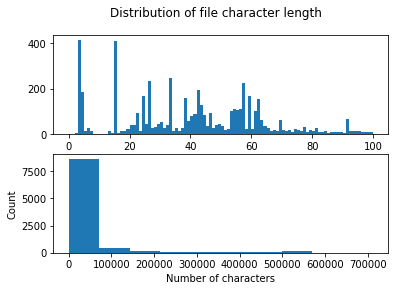

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Distribution of file character length')
ax1.hist(lengths, bins =100, range=(0,100))
ax2.hist(lengths)
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.show()

The corpus seems to have 1) many articles with <=5 characters (which can probably be discarded) and 2) a very long tail.

Currently, the corpus has less than 10k rows which is not a lot, so in order to increase its size, each article will be split into sentences and each sentence will be treated as a single row. This should considerably increase the size of the dataset considering there are articles with 500k+ characters.

In [ ]:
corpus = []
for file in files:
    file = open(os.path.join(CORPUS_PATH, file)).read()
    file = preprocess(file)
    for sent in nltk.tokenize.sent_tokenize(file):
        corpus.append(sent)

In [ ]:
print("Number of sentences in the corpus: {}".format(len(corpus)))
corpus[-5:]

Number of sentences in the corpus: 2208004


['\nForwarding of texts adopted during the sitting: see Minutes',
 '\n25.',
 '2006 discharge: European Agency for Reconstruction (',
 '\n: see Minutes',
 '\nVoting time\n\nThe next item is the vote.']

We don't want sentences such as '\n25' in the corpus so we'll prune all sentences whose length is lower than 5.

In [ ]:
pruned = [s for s in corpus if len(s) >=5]
len(pruned)

2189605

In [ ]:
pruned[-5:]

["The final wording would then be 'Calls on the countries in the Six-Party Talks to continue working together to ensure that the talks on ending the DPRK nuclear programme are resumed'.",
 '\nForwarding of texts adopted during the sitting: see Minutes',
 '2006 discharge: European Agency for Reconstruction (',
 '\n: see Minutes',
 '\nVoting time\n\nThe next item is the vote.']

"'\n: see Minutes'," are not sentences; we can prune rows that don't end with punctuation.

In [ ]:
pruned = [s for s in pruned if s.endswith('.')]
len(pruned)

2102180

In [ ]:
data = pd.Series(pruned)

In [ ]:
lens = [len(s) for s in data]
print("min and max lengths: {} and {}.".format(min(lens), max(lens)))

min and max lengths: 1 and 6791.


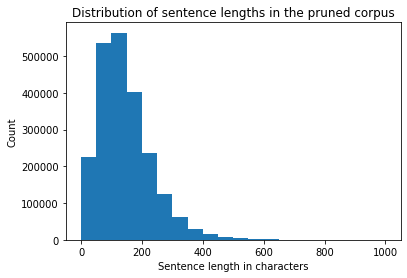

In [ ]:
plt.hist(lens, range=(0, 1000), bins=20)
plt.title("Distribution of sentence lengths in the pruned corpus")
plt.xlabel("Sentence length in characters")
plt.ylabel("Count")
plt.show()

This distribution makes more sense.

## Split the corpus into train and evaluation sets

Finetuning scripts expect a single file as input, consisting of untokenized text, with one sentence per line, and one blank line between documents, so the code below saves the data like that.

In [ ]:
train_split = 0.9
train_data_size = int(len(data)*train_split)

with open(os.path.join(lm_data_dir,'train.txt') , 'w') as f:
    for item in data[:train_data_size]:
        f.write("%s\n" % item)

with open(os.path.join(lm_data_dir,'eval.txt') , 'w') as f:
    for item in data[train_data_size:]:
        f.write("%s\n" % item)

#### Save train and eval files to gdrive for easier loading

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The fine-tuning script expects documents to be in a single line, with each document separated by a newline character. These files are saved on gcloud for easier access.

In [ ]:
with open('/content/gdrive/My Drive/train.txt', 'w') as f:
  for item in data[:train_data_size]:
        f.write("%s\n\n" % item)

with open('/content/gdrive/My Drive/eval.txt', 'w') as f:
  for item in data[train_data_size:]:
        f.write("%s\n\n" % item)